In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('results.csv', sep=';')
df.head()

,p,n,time
0,1,1000000,7.778140
1,2,1000000,4.229689
2,3,1000000,3.501831
3,4,1000000,2.336185
4,5,1000000,1.846123


In [3]:
for n in df.n.unique():
    for p in df.p.unique():
        df.loc[(df.p==p)&(df.n==n),'mean_time'] = df[(df.p==p)&(df.n==n)]['time'].mean()

In [4]:
for n in df.n.unique():
    for p in df.p.unique():
        p_1_time = (df[(df.n==n)&(df.p==1)]['mean_time']).iloc[0]
        own_time = df[(df.p==p)&(df.n==n)]['mean_time'].iloc[0]
        df.loc[(df.p==p)&(df.n==n),'accel'] = p_1_time/own_time

In [5]:
df['eff'] = df['accel']/df['p']

In [6]:
df[(df.p==2)&(df.n==1000)]

,p,n,time,mean_time,accel,eff
22,2,1000,0.005714,0.005571,1.475428,0.737714
50,2,1000,0.005538,0.005571,1.475428,0.737714
78,2,1000,0.005461,0.005571,1.475428,0.737714


In [7]:
def amdal(p, f):
    return 1/(f + (1-f)/p)

In [8]:
def plot_save_graphs(x_label, y_label, fixed='p'):
    
    def _appr_accel(n, p):
        return 6*n/(6*n/p + 6 + np.log2(p))
    
    def _appr_eff(n, p):
        return _appr_accel(n, p)/p
    
    def _appr_amdal(n, p, accels):
        if len(np.array(p).reshape(-1)) == 1:
            p = np.array([p]*len(accels))
        elif len(np.array(accels).reshape(-1)) == 1:
            accels = np.array([accels]*len(p))
        from scipy.optimize import curve_fit
        popt, pcov = curve_fit(amdal, p, accels)
        return amdal(p, popt[0])
    
    def _routine(data, x_label, y_label, fixed_value):
        x_data, y_data = data[x_label], data[y_label]
        plt.scatter(x_data, y_data, label='real')
        p, n = (fixed_value, x_data)
        if x_label == 'p':
            p, n = (n, p)
        # Approximation
        if y_label == 'accel':
            plt.scatter(x_data, _appr_accel(n, p), color='red', label='theor')
            if x_label == 'p':
                plt.scatter(x_data, _appr_amdal(n, p, y_data), color='green', label='amdal')
        elif y_label == 'eff':
            plt.scatter(x_data, _appr_eff(n, p), color='red', label='theor')
        plt.xlabel(x_label)
        plt.ylabel(y_label)
        plt.legend()
        plt.title(f'{y_label}, {fixed}={fixed_value}')
        plt.savefig(f'{y_label}_{fixed}_{fixed_value}', dpi=120)
        plt.show()
    if fixed == 'n':
        for n in df.n.unique():
            data = df[df.n==n]
            _routine(data, x_label, y_label, n)
    elif fixed == 'p':
        for p in df.p.unique():
            data = df[df.p==p]
            _routine(data, x_label, y_label, p)
    else:
        raise ValueError('Not implemented')

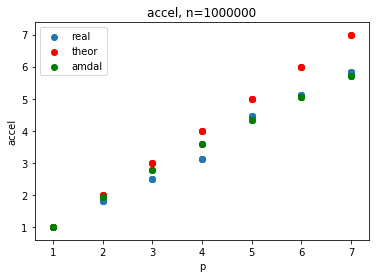

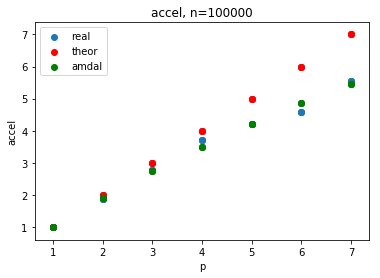

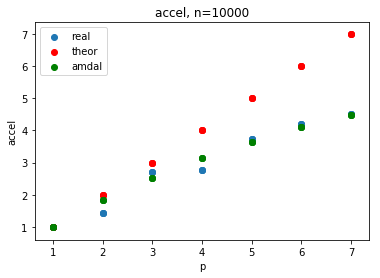

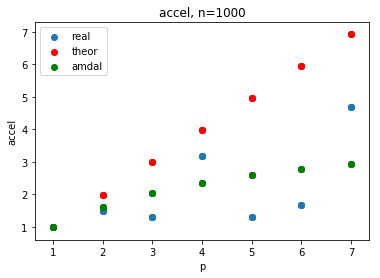

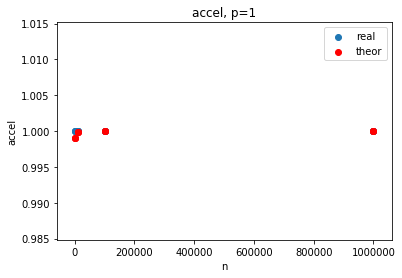

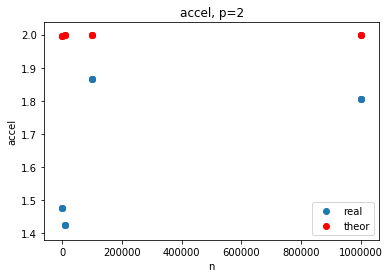

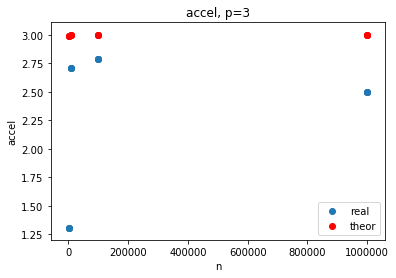

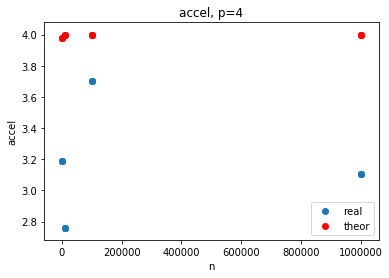

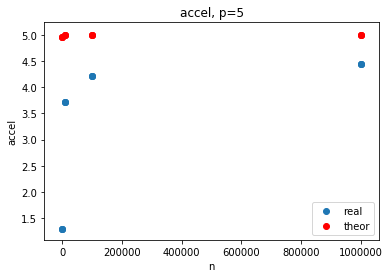

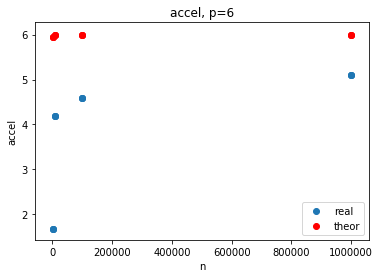

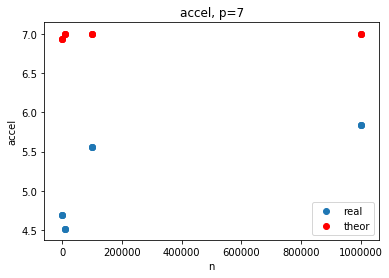

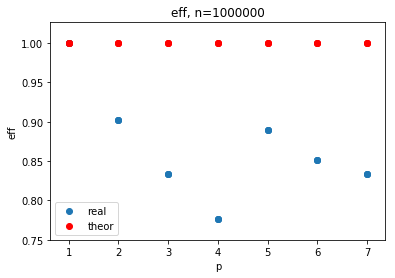

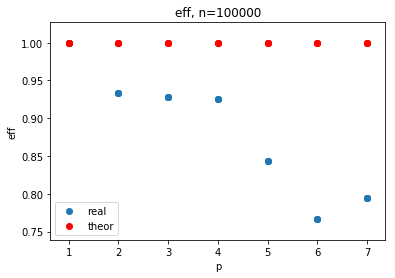

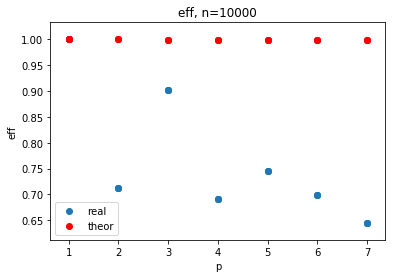

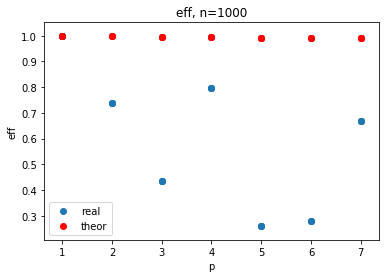

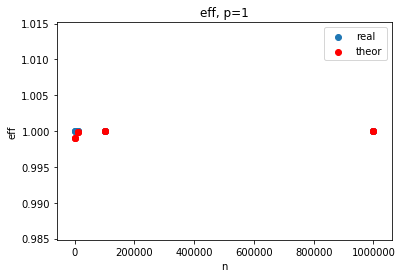

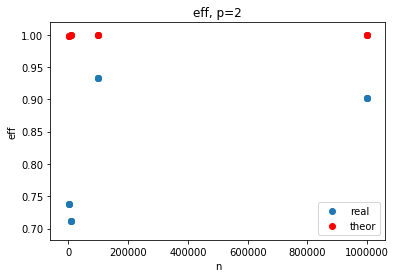

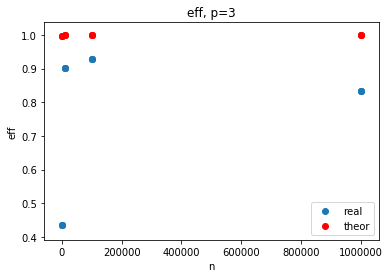

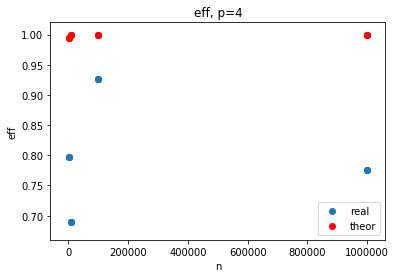

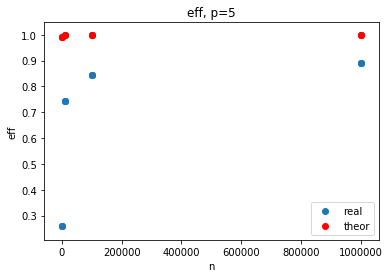

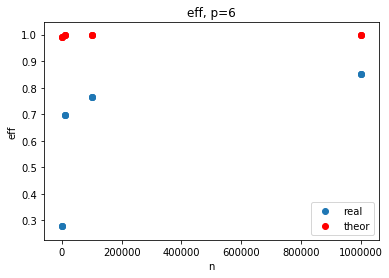

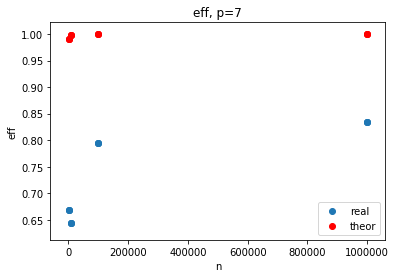

In [9]:
plot_save_graphs('p', 'accel', fixed='n')
plot_save_graphs('n', 'accel', fixed='p')
plot_save_graphs('p', 'eff', fixed='n')
plot_save_graphs('n', 'eff', fixed='p')